# Mixture Models


Notebook to play around with the Iris dataset and Mixture Models


In [1]:
%load_ext nb_black
import seaborn as sns
import pymc3 as pm
import pandas as pd
import numpy as np
import arviz as az

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


<IPython.core.display.Javascript object>

In [2]:
fish_df = pd.read_csv("./data/Fish.csv")
fish_df

,Species,Weight,Length1,Length2,Length3,Height,Width
0,Bream,242.0,23.2,25.4,30.0,11.5200,4.0200
1,Bream,290.0,24.0,26.3,31.2,12.4800,4.3056
2,Bream,340.0,23.9,26.5,31.1,12.3778,4.6961
3,Bream,363.0,26.3,29.0,33.5,12.7300,4.4555
4,Bream,430.0,26.5,29.0,34.0,12.4440,5.1340
...,...,...,...,...,...,...,...
154,Smelt,12.2,11.5,12.2,13.4,2.0904,1.3936
155,Smelt,13.4,11.7,12.4,13.5,2.4300,1.2690
156,Smelt,12.2,12.1,13.0,13.8,2.2770,1.2558
157,Smelt,19.7,13.2,14.3,15.2,2.8728,2.0672


<IPython.core.display.Javascript object>

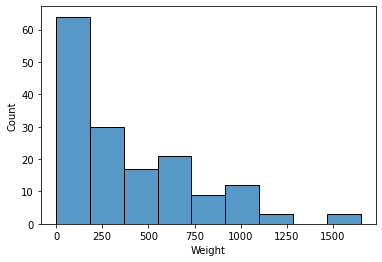

<IPython.core.display.Javascript object>

In [3]:
_ = sns.histplot(fish_df.Weight)

In [4]:
fish_df.groupby(["Species"]).agg(
    mean_weight=pd.NamedAgg(column="Weight", aggfunc="mean"),
    std_weight=pd.NamedAgg(column="Weight", aggfunc="std"),
    mean_height=pd.NamedAgg(column="Height", aggfunc="mean"),
    std_height=pd.NamedAgg(column="Height", aggfunc="std"),
    mean_width=pd.NamedAgg(column="Width", aggfunc="mean"),
    std_width=pd.NamedAgg(column="Width", aggfunc="std"),
)


,mean_weight,std_weight,mean_height,std_height,mean_width,std_width
Species,,,,,,
Bream,617.828571,209.205709,15.183211,1.964707,5.427614,0.721509
Parkki,154.818182,78.755086,8.962427,1.615650,3.220736,0.643347
Perch,382.239286,347.617717,7.861870,2.878177,4.745723,1.774626
Pike,718.705882,494.140765,7.713771,1.664228,5.086382,1.140269
Roach,152.050000,88.828916,6.694795,1.261192,3.657850,0.690371
Smelt,11.178571,4.131526,2.209371,0.351780,1.340093,0.286611
Whitefish,531.000000,309.602972,10.027167,1.830201,5.473050,1.194258


<IPython.core.display.Javascript object>

In [5]:
n_clusters = 7
n_observations = len(fish_df.Weight)
with pm.Model() as model:
    weight_sigma = pm.HalfNormal("weight_sigma", sigma=1)
    height_sigma = pm.HalfNormal("height_sigma", sigma=1)
    width_sigma = pm.HalfNormal("width_sigma", sigma=1)

    p = pm.Dirichlet("p", a=np.ones(n_clusters))
    category = pm.Categorical("category", p=p, shape=n_observations)

    weight_means = pm.Normal(
        "weight_means", [np.mean(fish_df.Weight)] * n_clusters, sd=1, shape=n_clusters
    )
    height_means = pm.Normal(
        "height_means", [np.mean(fish_df.Height)] * n_clusters, sd=1, shape=n_clusters
    )
    width_means = pm.Normal(
        "width_means", [np.mean(fish_df.Width)] * n_clusters, sd=1, shape=n_clusters
    )

    y_weigth = pm.Normal(
        "y_weigth", mu=weight_means[category], sd=weight_sigma, observed=fish_df.Weight
    )
    y_heigth = pm.Normal(
        "y_heigth", mu=height_means[category], sd=height_sigma, observed=fish_df.Height
    )
    y_width = pm.Normal(
        "y_width", mu=width_means[category], sd=width_sigma, observed=fish_df.Width
    )

    trace = pm.sample(10000)

<ipython-input-5-6b2e2d8f27e3>:31: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(10000)
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [width_means, height_means, weight_means, p, width_sigma, height_sigma, weight_sigma]
>CategoricalGibbsMetropolis: [category]


Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 330 seconds.
There were 5994 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.27480067458265195, but should be close to 0.8. Try to increase the number of tuning steps.
There were 19 divergences after tuning. Increase `target_accept` or reparameterize.
There were 2683 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.48512088933714076, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


<IPython.core.display.Javascript object>

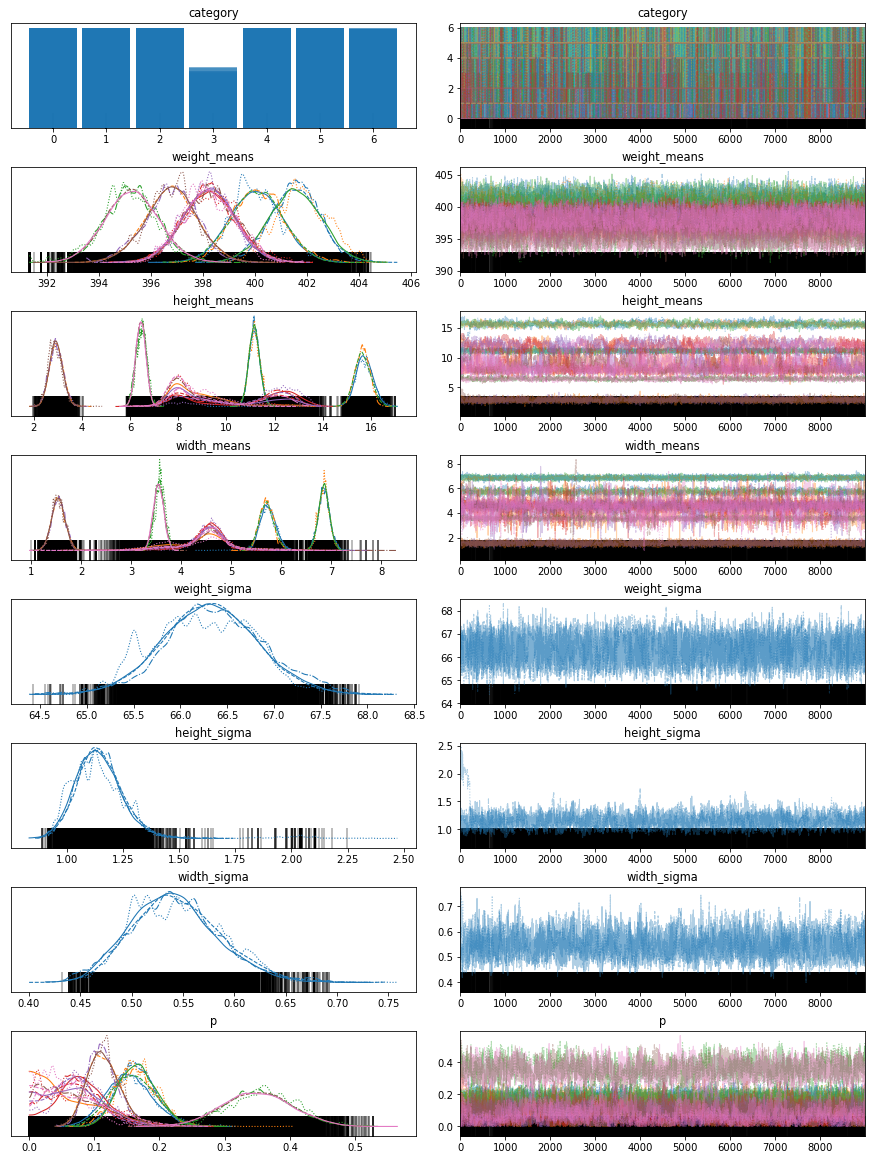

<IPython.core.display.Javascript object>

In [6]:
with model:
    pm.plot_trace(trace[1000:])

In [7]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaled_fish_df = scaler.fit_transform(fish_df.drop(columns=["Species"]))
scaled_fish_df = pd.DataFrame(scaled_fish_df, columns=fish_df.columns[1:])
scaled_fish_df["Species"] = fish_df["Species"]
scaled_fish_df

,Weight,Length1,Length2,Length3,Height,Width,Species
0,-0.438072,-0.305789,-0.282303,-0.106020,0.596579,-0.236529,Bream
1,-0.303562,-0.225507,-0.198054,-0.002337,0.821261,-0.066579,Bream
2,-0.163448,-0.235542,-0.179332,-0.010977,0.797341,0.165793,Bream
3,-0.098995,0.005302,0.054694,0.196390,0.879771,0.022621,Bream
4,0.088759,0.025372,0.054694,0.239592,0.812835,0.426371,Bream
...,...,...,...,...,...,...,...
154,-1.082039,-1.479903,-1.517960,-1.540309,-1.610359,-1.799403,Smelt
155,-1.078676,-1.459833,-1.499238,-1.531669,-1.530878,-1.873547,Smelt
156,-1.082039,-1.419692,-1.443072,-1.505748,-1.566687,-1.881402,Smelt
157,-1.061022,-1.309305,-1.321378,-1.384784,-1.427243,-1.398568,Smelt


<IPython.core.display.Javascript object>

In [8]:
scaled_fish_df.groupby(["Species"]).agg(
    mean_weight=pd.NamedAgg(column="Weight", aggfunc="mean"),
    std_weight=pd.NamedAgg(column="Weight", aggfunc="std"),
    mean_height=pd.NamedAgg(column="Height", aggfunc="mean"),
    std_height=pd.NamedAgg(column="Height", aggfunc="std"),
    mean_width=pd.NamedAgg(column="Width", aggfunc="mean"),
    std_width=pd.NamedAgg(column="Width", aggfunc="std"),
)

,mean_weight,std_weight,mean_height,std_height,mean_width,std_width
Species,,,,,,
Bream,0.615109,0.586255,1.453930,0.459827,0.601090,0.429343
Parkki,-0.682381,0.220695,-0.002005,0.378133,-0.712141,0.382832
Perch,-0.045081,0.974126,-0.259583,0.673619,0.195322,1.056014
Pike,0.897797,1.384726,-0.294245,0.389502,0.398036,0.678532
Roach,-0.690138,0.248925,-0.532730,0.295174,-0.452031,0.410814
Smelt,-1.084901,0.011578,-1.582515,0.082332,-1.831243,0.170552
Whitefish,0.371790,0.867598,0.247191,0.428347,0.628127,0.710659


<IPython.core.display.Javascript object>

In [49]:
with pm.Model() as model_2:
    weight_sigma = pm.HalfNormal("weight_sigma", sigma=1)
    height_sigma = pm.HalfNormal("height_sigma", sigma=1)
    width_sigma = pm.HalfNormal("width_sigma", sigma=1)
    length1_sigma = pm.HalfNormal("length1_sigma", sigma=1)
    length2_sigma = pm.HalfNormal("length2_sigma", sigma=1)
    length3_sigma = pm.HalfNormal("length3_sigma", sigma=1)

    p = pm.Dirichlet("p", a=np.ones(n_clusters))
    category = pm.Categorical("category", p=p, shape=n_observations)

    weight_means = pm.Normal("weight_means", [0] * n_clusters, sd=1, shape=n_clusters)
    height_means = pm.Normal("height_means", [0] * n_clusters, sd=1, shape=n_clusters)
    width_means = pm.Normal("width_means", [0] * n_clusters, sd=1, shape=n_clusters)
    length1_means = pm.Normal("length1_means", [0] * n_clusters, sd=1, shape=n_clusters)
    length2_means = pm.Normal("length2_means", [0] * n_clusters, sd=1, shape=n_clusters)
    length3_means = pm.Normal("length3_means", [0] * n_clusters, sd=1, shape=n_clusters)

    y_weigth = pm.Normal(
        "y_weigth",
        mu=weight_means[category],
        sd=weight_sigma,
        observed=scaled_fish_df.Weight,
    )
    y_heigth = pm.Normal(
        "y_heigth",
        mu=height_means[category],
        sd=height_sigma,
        observed=scaled_fish_df.Height,
    )
    y_width = pm.Normal(
        "y_width",
        mu=width_means[category],
        sd=width_sigma,
        observed=scaled_fish_df.Width,
    )
    y_length1 = pm.Normal(
        "y_length1",
        mu=length1_means[category],
        sd=length1_sigma,
        observed=scaled_fish_df.Length1,
    )
    y_length2 = pm.Normal(
        "y_length2",
        mu=length2_means[category],
        sd=length2_sigma,
        observed=scaled_fish_df.Length2,
    )
    y_length3 = pm.Normal(
        "y_length3",
        mu=length3_means[category],
        sd=length3_sigma,
        observed=scaled_fish_df.Length3,
    )

    trace_2 = pm.sample(10000)

<ipython-input-49-15844ccb7f79>:56: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace_2 = pm.sample(10000)
Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
INFO:pymc3:CompoundStep
>NUTS: [length3_means, length2_means, length1_means, width_means, height_means, weight_means, p, length3_sigma, length2_sigma, length1_sigma, width_sigma, height_sigma, weight_sigma]
INFO:pymc3:>NUTS: [length3_means, length2_means, length1_means, width_means, height_means, weight_means, p, length3_sigma, length2_sigma, length1_sigma, width_sigma, height_sigma, weight_sigma]
>CategoricalGibbsMetropolis: [category]
INFO:pymc3:>CategoricalGibbsMetropolis: [category]


Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 341 seconds.
INFO:pymc3:Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 341 seconds.
C:\Users\Sebastian\.conda\envs\pymc3\lib\site-packages\arviz\stats\diagnostics.py:561: RuntimeWarning: invalid value encountered in double_scalars
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
ERROR:pymc3:The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.
ERROR:pymc3:The estimated number of effective samples is smaller than 200 for some parameters.


<IPython.core.display.Javascript object>

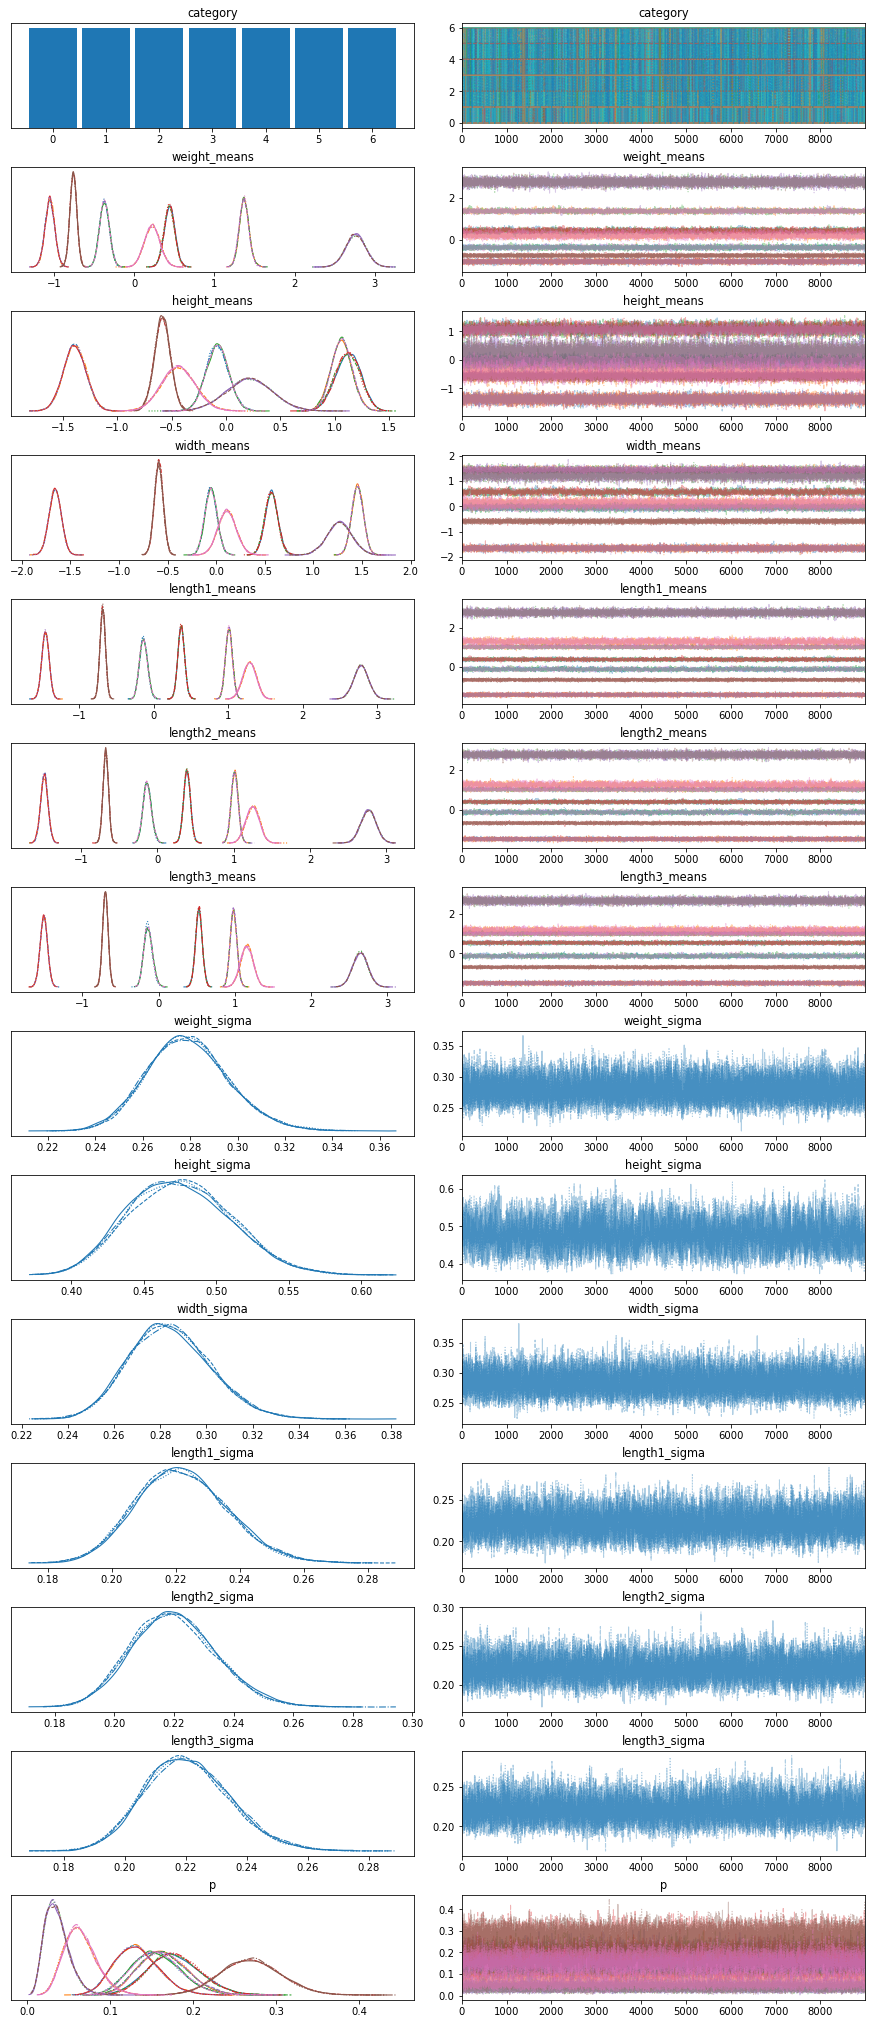

<IPython.core.display.Javascript object>

In [50]:
with model_2:
    pm.plot_trace(trace_2[1000:])

In [51]:
groups = [
    f"Group {n+1}"
    for n in list(trace_2.get_values("category", burn=1000, combine=False)[1][1])
]
fish_df["Group"] = groups
fish_df

,Species,Weight,Length1,Length2,Length3,Height,Width,group,Group
0,Bream,242.0,23.2,25.4,30.0,11.5200,4.0200,Group 5,Group 1
1,Bream,290.0,24.0,26.3,31.2,12.4800,4.3056,Group 3,Group 1
2,Bream,340.0,23.9,26.5,31.1,12.3778,4.6961,Group 3,Group 1
3,Bream,363.0,26.3,29.0,33.5,12.7300,4.4555,Group 3,Group 1
4,Bream,430.0,26.5,29.0,34.0,12.4440,5.1340,Group 3,Group 4
...,...,...,...,...,...,...,...,...,...
154,Smelt,12.2,11.5,12.2,13.4,2.0904,1.3936,Group 6,Group 5
155,Smelt,13.4,11.7,12.4,13.5,2.4300,1.2690,Group 6,Group 5
156,Smelt,12.2,12.1,13.0,13.8,2.2770,1.2558,Group 6,Group 5
157,Smelt,19.7,13.2,14.3,15.2,2.8728,2.0672,Group 6,Group 5


<IPython.core.display.Javascript object>

In [52]:
fish_df.groupby(["Species", "Group"]).count()[["Weight"]].reset_index().pivot_table(
    index=["Species"], columns=["Group"]
).fillna(0)

Weight                                                
Group     Group 1 Group 2 Group 3 Group 4 Group 5 Group 6 Group 7
Species                                                          
Bream         4.0     0.0     0.0    24.0     0.0     0.0     7.0
Parkki        2.0     0.0     0.0     0.0     2.0     7.0     0.0
Perch        10.0     0.0     0.0     3.0     4.0    23.0    16.0
Pike          2.0     9.0     5.0     1.0     0.0     0.0     0.0
Roach         2.0     0.0     0.0     1.0     1.0    16.0     0.0
Smelt         0.0     0.0     0.0     0.0    14.0     0.0     0.0
Whitefish     3.0     0.0     0.0     1.0     0.0     0.0     2.0

<IPython.core.display.Javascript object>

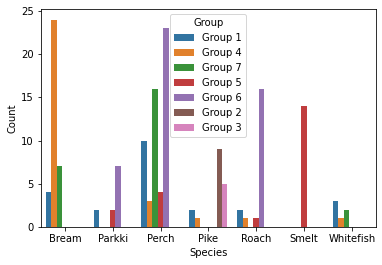

<IPython.core.display.Javascript object>

In [53]:
plot_df = (
    fish_df.groupby(["Species", "Group"])
    .count()[["Weight"]]
    .reset_index()
    .rename(columns={"Weight": "Count"})
)
_ = sns.barplot(data=plot_df, x="Species", y="Count", hue="Group")